In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


In [ ]:
brain_df = pd.read_csv("https://raw.githubusercontent.com/rmarquez93/data_masterbdds2022/main/Act%202%20Modulo%206.csv")
brain_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Para la transformación de las variables utilizo el label encoder principalmente para no generar variables dummies. El motivo de esto es que, para completar los valores faltantes de smoking status, no quiero generar tantas variabels como categorías-1 haya sino que quiero utilizar solamente una variable categórica con los distintos tipos de posibilidades.

A pesar de lo anterior, label encoder no es la opción ideal ya que no se tratan de variables categóricas ordinales, sino nominales.

In [ ]:
for i in ["gender", "ever_married", "work_type", "Residence_type"]:
  brain_df[i] = preprocessing.LabelEncoder().fit_transform(brain_df[i])

brain_df.head()

#Elimino nulos de BMI

brain_df.dropna(subset=['bmi'], inplace = True)
brain_df.reset_index(inplace = True)

In [ ]:
brain_df

,index,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,9046,1,67.0,0,1,1,2,1,228.69,36.6,formerly smoked,1
1,2,31112,1,80.0,0,1,1,2,0,105.92,32.5,never smoked,1
2,3,60182,0,49.0,0,0,1,2,1,171.23,34.4,smokes,1
3,4,1665,0,79.0,1,0,1,3,0,174.12,24.0,never smoked,1
4,5,56669,1,81.0,0,0,1,2,1,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,5104,14180,0,13.0,0,0,0,4,0,103.08,18.6,Unknown,0
4905,5106,44873,0,81.0,0,0,1,3,1,125.20,40.0,never smoked,0
4906,5107,19723,0,35.0,0,0,1,3,0,82.99,30.6,never smoked,0
4907,5108,37544,1,51.0,0,0,1,2,0,166.29,25.6,formerly smoked,0


Para el caso específico del smoking_status genero un encoding por separado para poder tener un mapeo que me indique cual número corresponde al status "unknown" y asi eliminarlo del subset posteriormente.

In [ ]:
le = preprocessing.LabelEncoder()
brain_df["smoking_status"] = le.fit_transform(brain_df["smoking_status"])
mapping = dict(zip(le.classes_, range(len(le.classes_))))

mapping

{'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}

Para la imputación de valores faltantes para el status de fumador, decido generar un árbol de decisión que clasifique su status en función del resto de las variables presentes en el dataset.

In [ ]:
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier

#Genero data frame sin smoking status = Unknown. Para el modelo no tomo la variable stroke como predictora ya que generaría
# una correlación que quiero evitar para generar el KNN

smoking_df = brain_df.drop(brain_df.loc[brain_df['smoking_status']==0].index, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(smoking_df[["gender","age","hypertension",
                                                                "heart_disease","ever_married",
                                                                "work_type","Residence_type",
                                                                "avg_glucose_level"]], smoking_df['smoking_status'],
                                                    stratify = smoking_df['smoking_status'],
                                                    random_state=42, test_size=0.3 )
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(2398, 8) (2398,)
(1028, 8) (1028,)


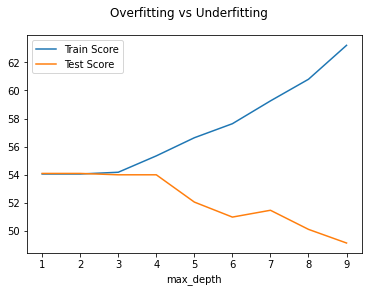

In [ ]:
md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1,10)):
  tree_model = DecisionTreeClassifier(random_state=0, max_depth=maxdepth)
  tree_model.fit(X_train, y_train)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X_train, y_train))
  score_test_list.append(100.0*tree_model.score(X_test, y_test))

df = pd.DataFrame({"max_depth":md_list,
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("max_depth", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show();

A raíz del gráfico superior, decido utilizar un max_depth = 4.

In [ ]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=4)
tree_model.fit(X_train, y_train)
pred_train = tree_model.predict(X_train)
pred_test = tree_model.predict(X_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*tree_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*tree_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 55.34
Precisión sobre los datos de test: 53.99


Una vez generado el árbol de decisión, predigo los valores de smoking status para aquellos casos donde el smoking status es unknown y creo un array con dicha información.

A partir de lo anterior, reemplazo los valores "unknown" con los datos predichos.

In [ ]:
smoking_array = tree_model.predict(
                                  brain_df.loc[brain_df["smoking_status"]== 0,
                                               ["gender","age","hypertension",
                                                "heart_disease","ever_married",
                                                "work_type","Residence_type",
                                                "avg_glucose_level"]])

len(smoking_array)

1483

In [ ]:
brain_df.loc[brain_df["smoking_status"]==0,"smoking_status"] = smoking_array

A partir de la generación del árbol de decisión y de la predicción del status de fumador, se sustituye el dataframe donde dicha condición es "unknown" (valor = 0) con los valores que dicho modelo arroja.

Como se puede notar debajo, ya no habrán valores unknown.

In [ ]:
brain_df["smoking_status"].unique()

array([1, 2, 3])

In [ ]:
#Escalado de variables

scaler = StandardScaler()
scaled = scaler.fit(brain_df.iloc[:,0:-1]).transform(brain_df.iloc[:,0:-1])
dfs = pd.DataFrame(scaled, columns=brain_df.columns[:-1])
dfs = pd.concat([dfs, brain_df["stroke"]], axis=1)
dfs


,index,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,-1.749969,-1.334653,1.198428,1.070138,-0.318067,4.381968,0.729484,-0.155697,0.985640,2.777698,0.981345,-1.626843,1
1,-1.748609,-0.283539,1.198428,1.646563,-0.318067,4.381968,0.729484,-0.155697,-1.014569,0.013842,0.459269,0.078147,1
2,-1.747929,1.101211,-0.833023,0.272012,-0.318067,-0.228208,0.729484,-0.155697,0.985640,1.484132,0.701207,1.783137,1
3,-1.747249,-1.686247,-0.833023,1.602222,3.143994,-0.228208,0.729484,0.759651,-1.014569,1.549193,-0.623083,0.078147,1
4,-1.746569,0.933870,1.198428,1.690903,-0.318067,-0.228208,0.729484,-0.155697,0.985640,1.821368,0.013595,-1.626843,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,1.720736,-1.090095,-0.833023,-1.324241,-0.318067,-0.228208,-1.370831,1.674998,-1.014569,-0.050094,-1.310695,0.078147,0
4905,1.722096,0.371967,-0.833023,1.690903,-0.318067,-0.228208,0.729484,0.759651,0.985640,0.447882,1.414286,0.078147,0
4906,1.722776,-0.826054,-0.833023,-0.348753,-0.318067,-0.228208,0.729484,0.759651,-1.014569,-0.502369,0.217332,0.078147,0
4907,1.723456,0.022850,1.198428,0.360692,-0.318067,-0.228208,0.729484,-0.155697,-1.014569,1.372920,-0.419346,-1.626843,0


Con los datos ya pre procesados de la forma requerida, busco el valor de k óptimo para el modelo que voy a generar.

In [ ]:
X = dfs.iloc[:,2:-1] #Dejo de tomar la columna index y id para computar las variables predictoras
Y = dfs.iloc[:,-1]

preds_list = []
score_list = []
k_list = []

for k in list(range(1, 20, 2)):
  knn_model = KNeighborsClassifier(n_neighbors=k, weights="uniform", metric="minkowski")
  preds = cross_val_predict(knn_model, X, Y, cv=3, method="predict", n_jobs=3)
  score = cross_val_score(knn_model, X, Y, cv=3, scoring="accuracy")
  k_list.append(k)
  preds_list.append(preds)
  score_list.append(score.mean())

In [ ]:
df_scores = pd.DataFrame({"K":k_list,
                   "score":score_list
                   })

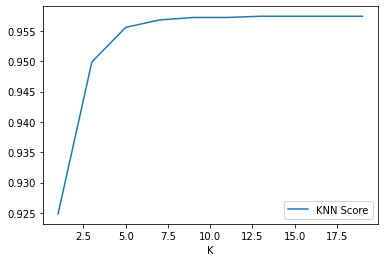

In [ ]:
df_scores.set_index("K")["score"].plot(label="KNN Score")
plt.legend()
plt.show();

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=7, weights="uniform", metric="minkowski")
knn_model.fit(X, Y)
preds = cross_val_predict(knn_model, X, Y, cv=3, method="predict", n_jobs=3) #predicciones para comparar en la confusion matrix
score = cross_val_score(knn_model, X, Y, cv=3, scoring="accuracy", n_jobs=3) #accuracy del modelo
score

array([0.95662798, 0.95660147, 0.95721271])

A partir de la matriz de confusión generada debajo, se pueden notar:

4697 negativos predichos correctamente.
3 negativos que se predijeron como positivos (falsos positivos).
209 positivos que se predijeron como negativos (falsos negativos).
0 positivos predichos como positivos (verdaderos positivos).

Como se puede ver, el modelo no predice suficientemente bien a la clase "true" debido principalmente a que son datos imbalanceados; hay muchos registros que no han tenido un accidente cerebro vascular sobre el total de la muestra y eso genera un buen nivel de predicción para los negativos pero no así para los casos positivos.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y, preds)


array([[4697,    3],
       [ 209,    0]])

In [ ]:
from sklearn.metrics import classification_report
print(f"Informe de Clasificación:\n"
      f"{classification_report(Y, preds)}")

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4700
           1       0.00      0.00      0.00       209

    accuracy                           0.96      4909
   macro avg       0.48      0.50      0.49      4909
weighted avg       0.92      0.96      0.94      4909



Podemos ver a partir de lo anterior que, si bien el modelo tiene una buena accurracy general (del 96%), esto es generado principalmente debido al mencionado imbalanceo de los datos; la clase 0 tiene una precision del 96% y un recall del 100%.

Por el lado de los positivos, dichas métricas disminuyen drásticamente siendo del 0% en ambos casos.

[[4697    3]
 [ 209    0]]
Confusion matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


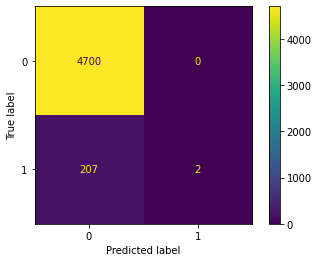

In [ ]:
print(confusion_matrix(Y, preds))

print(f"Confusion matrix:\n")
disp = plot_confusion_matrix(knn_model, X, Y, cmap=plt.cm.viridis,)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


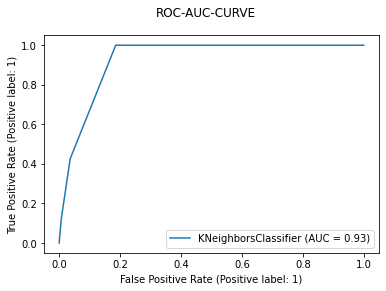

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(knn_model, X, Y)
plt.suptitle("ROC-AUC-CURVE")
plt.show()

En este caso se puede notar como la curva ROC está fuertemente influenciada por el imbalanceo de datos. Muy facilmente se llega a una tasa de casi el 100% de verdaderos positivos debido a que hay una gran cantidad de valores "0" predichos correctamente.

In [ ]:
probs = cross_val_predict(knn_model, X, Y, cv=3, method="predict_proba", n_jobs=3)
probs

array([[0.85714286, 0.14285714],
       [1.        , 0.        ],
       [0.85714286, 0.14285714],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

Genero un array con las probabilidades para las predicciones de cada clase.

In [ ]:
df_dict = {"prob_class0": probs[:,0],
           "prob_class1": probs[:,1],
           "preds":preds}

df_probs = pd.DataFrame(df_dict)
df_probs.head()

,prob_class0,prob_class1,preds
0,0.857143,0.142857,0
1,1.000000,0.000000,0
2,0.857143,0.142857,0
3,0.857143,0.142857,0
4,0.714286,0.285714,0


In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, limite = precision_recall_curve(Y,probs[:,1])

A partir de lo anterior, genero una curva de precision/recall para entender cómo varían dichas métricas cuando se modifica el valor de la probabilidad que se le da a cada clase al predecir.

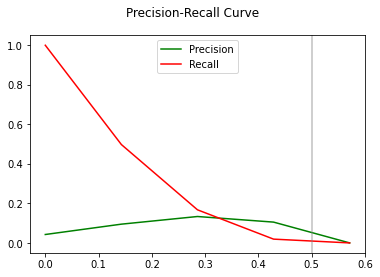

In [ ]:
plt.plot(limite, precision[:-1], c="green", label="Precision")
plt.plot(limite, recall[:-1], c="red", label="Recall")
plt.axvline(0.5, alpha=0.5, c="gray")
plt.suptitle("Precision-Recall Curve")
plt.legend()
plt.show()

A partir de la grafica precision / recall generada anteriormente voy a crear las matrices de confusión para los valores de 30%  y 60% para entender cómo cambian dichas métricas.

In [ ]:
df_probs["preds_30"] = 0
df_probs["preds_60"] = 0


df_probs.loc[df_probs["prob_class1"]>0.3, "preds_30"] = 1
df_probs.loc[df_probs["prob_class1"]>0.6, "preds_60"] = 1


df_probs

,prob_class0,prob_class1,preds,preds_30,preds_60
0,0.857143,0.142857,0,0,0
1,1.000000,0.000000,0,0,0
2,0.857143,0.142857,0,0,0
3,0.857143,0.142857,0,0,0
4,0.714286,0.285714,0,0,0
...,...,...,...,...,...
4904,1.000000,0.000000,0,0,0
4905,0.857143,0.142857,0,0,0
4906,1.000000,0.000000,0,0,0
4907,1.000000,0.000000,0,0,0


In [ ]:
#Matriz de confusión para prob = 0.3
preds_30=df_probs["preds_30"].values

print("Matriz de confusión: \n {} \n ".format(confusion_matrix(Y, preds_30)))


print(f"Informe de Clasificación:\n"
      f"{classification_report(Y, preds_30)}")


Matriz de confusión: 
 [[4666   34]
 [ 205    4]] 
 
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4700
           1       0.11      0.02      0.03       209

    accuracy                           0.95      4909
   macro avg       0.53      0.51      0.50      4909
weighted avg       0.92      0.95      0.93      4909



In [ ]:
#Matriz de confusión para prob = 0.6
preds_60=df_probs["preds_60"].values

print("Matriz de confusión: \n {} \n ".format(confusion_matrix(Y, preds_60)))


print(f"Informe de Clasificación:\n"
      f"{classification_report(Y, preds_60)}")

Matriz de confusión: 
 [[4700    0]
 [ 209    0]] 
 
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4700
           1       0.00      0.00      0.00       209

    accuracy                           0.96      4909
   macro avg       0.48      0.50      0.49      4909
weighted avg       0.92      0.96      0.94      4909



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A partir de lo anterior, se puede notar cómo varían los valores de precision/recall cuando se modifica la probabilidad asignada para la clasificación de clases.

Es a su vez interesante ver cómo la accurracy casi no cambia en todos los casos (original = 50%, 30% y 60%). Esto se debe al mencionado imbalanceo de los casos, donde los casos negativos tienen una preponderancia significativa sobre el total de casos. A pesar de lo anterior, es notorio que cuando se baja la probabilidad (dicho de otra forma, la "exigencia" o "rigurosidad" que le exigimos al modelo) la predicción de los valores "1" mejora.